In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from util import get_file_paths


In [15]:

file_paths=get_file_paths("../data/valve1")

In [16]:
dfs=[]

for file_path in file_paths:
    df = pd.read_csv(file_path,sep=';',index_col='datetime', parse_dates=True)
    dfs.append(df)
    
# Concatenate all the DataFrames in the list into a single DataFrame
valve1_df = pd.concat(dfs) #, ignore_index=True)


In [17]:
def calc_metrics(y_true,y_pred,threshold=0.5):
  y_labels = np.where(y_pred>=threshold,1,0)
  accuracy = accuracy_score(y_true, y_labels)
  cm = confusion_matrix(y_true, y_labels)
  f1 = f1_score(y_true, y_labels)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  true_pos = cm[1, 1]
  true_neg = cm[0, 0]
  false_pos = cm[0, 1]
  false_neg = cm[1, 0]
  mar = false_neg / (false_neg + true_pos)
  far = false_pos / (false_pos + true_neg)

  return { 
    'accuracy': accuracy,
    'cm': cm,
    'f1': f1, 
    'far': far, 
    'mar': mar, 
    'fpr': fpr,
    'tpr': tpr, 
    'thresholds': thresholds, 
    'roc_auc': roc_auc 
}
 


In [18]:
# TODO: rename `test` to "new model" and `baseline` to "old model"
def plot(baseline, test, title = 'Model Evaluation Metrics'):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
  fig.suptitle(title, fontsize=16, y=1.02)
  
  baseline_confusion_matrix_ax = ax[0]
  test_confusion_matrix_ax = ax[1]
  roc_curve_ax = ax[2]
  
  # Baseline Confusion Matrix in the first subplot
  ConfusionMatrixDisplay(confusion_matrix=baseline['cm']).plot(ax=baseline_confusion_matrix_ax)
  baseline_confusion_matrix_ax.set_title('Baseline Confusion Matrix')
  baseline_confusion_matrix_ax.set_xlabel('Predicted labels')
  baseline_confusion_matrix_ax.set_ylabel('True labels')

  # Test Confusion Matrix in the first subplot
  ConfusionMatrixDisplay(confusion_matrix=test['cm']).plot(ax=test_confusion_matrix_ax)
  test_confusion_matrix_ax.set_title('Test Confusion Matrix')
  test_confusion_matrix_ax.set_xlabel('Predicted labels')
  test_confusion_matrix_ax.set_ylabel('True labels')

  # ROC Curve in the second subplot
  roc_curve_ax.plot(baseline['fpr'], baseline['tpr'], color='green', lw=2, label=f"Baseline AUC = {baseline['roc_auc']:.2f}")
  roc_curve_ax.plot(test['fpr'], test['tpr'], color='darkorange', lw=2, label=f"Test AUC = {test['roc_auc']:.2f}")

  roc_curve_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  roc_curve_ax.set_xlabel('False Positive Rate')
  roc_curve_ax.set_ylabel('True Positive Rate')
  roc_curve_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
  roc_curve_ax.legend(loc='lower right')

  # Display the plot
  plt.tight_layout()
  plt.show()
  

In [19]:
def fit_model(df, model, feature = 'anomaly'):
    X = df.drop(feature, axis=1)
    y = df[feature]

    model_clone = clone(model)  # Clone the base model to avoid refitting the same model
    model_clone.fit(X, y)
    return model_clone
    
def fit_model_list(df, model, n):
    sample_models = []
    split_size = len(df) // n

    for i in range(n):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n - 1 else len(df)
        ordered_sample = df.iloc[start_idx:end_idx]
        
        model_clone = fit_model(ordered_sample, model)
        
        sample_models.append(model_clone)
    return sample_models

def predict_model_list(df, models, operation_var):
    """
    Runs each model on the test data and calculates the probability of not being an anomaly.
    
    Parameters:
    - df: Features of the test data.
    - models: A list of trained models.
    - operation_var: Operation to perform on the probabilities ('max' or 'avg').
    
    Returns:
    - labels: The predicted labels for the test data.
    - test_not_anomaly_proba: The probability of not being an anomaly for each test sample.
    """
  
    probas = []
    for model in models:
        # Predict_proba returns [prob_anomaly, prob_not_anomaly] for binary classification
        anomaly_probs = model.predict_proba(df)
        prob_not_anomaly = anomaly_probs[:, 1]
        probas.append(prob_not_anomaly)

    probas = np.array(probas)

    # Calculate based on operation_var
    if operation_var == 'max':
        not_anomaly_proba = np.max(probas, axis=0)
    elif operation_var == 'avg':
        not_anomaly_proba = np.mean(probas, axis=0)
    else:
        raise ValueError("operation_var must be 'max' or 'avg'")
    
    return not_anomaly_proba



In [20]:

# Split Valve data
total_rows = len(valve1_df)
index_70_percent = int(total_rows * 0.7)
index_90_percent = index_70_percent + int(total_rows * 0.2)


train_df = valve1_df.iloc[:index_70_percent]
valid_df = valve1_df.iloc[index_70_percent:index_90_percent]
test_df = valve1_df.iloc[index_90_percent:]

print(f"Shape:\n Valve1 total: {valve1_df.shape}\nTrain (70%) {train_df.shape}\nValid (20%) {valid_df.shape}\nTest (10%) {test_df.shape}\n")


Shape:
 Valve1 total: (18160, 10)
Train (70%) (12712, 10)
Valid (20%) (3632, 10)
Test (10%) (1816, 10)



In [21]:
# fit data to lightgbm model
model = lgb.LGBMClassifier()  # Base LightGBM model


model_baseline = fit_model(train_df, model)
# create list of n models
n = 10  # Number of models to fit
sample_model_list = fit_model_list(train_df, model, n=n)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4310, number of negative: 8402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1755
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339050 -> initscore=-0.667532
[LightGBM] [Info] Start training from score -0.667532


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 405, number of negative: 866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1576
[LightGBM] [Info] Number of data points in the train set: 1271, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318647 -> initscore=-0.759998
[LightGBM] [Info] Start training from score -0.759998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [22]:

X_test = test_df.drop('anomaly', axis=1)
y_test = test_df['anomaly']

# TOFO
max_base_predict = predict_model_list(X_test, [model_baseline], operation_var='max')
avg_base_predict = predict_model_list(X_test, [model_baseline], operation_var='avg')

max_test_predict = predict_model_list(X_test, sample_model_list, operation_var='max')
avg_test_predict = predict_model_list(X_test, sample_model_list, operation_var='avg')



In [23]:
baseline_metrics = calc_metrics(y_test,avg_base_predict)
print(f"Baseline:\naccuracy {baseline_metrics['accuracy']:.2f}\nf1 {baseline_metrics['f1']:.2f}\nfar {baseline_metrics['far']:.2f}\nmar {baseline_metrics['mar']:.2f}\nthresholds {baseline_metrics['thresholds']}")


Baseline:
accuracy 0.92
f1 0.91
far 0.07
mar 0.09
thresholds [1.99983319e+00 9.99833189e-01 9.99790665e-01 9.99790305e-01
 9.99788154e-01 9.99787355e-01 9.99782469e-01 9.99782451e-01
 9.99780764e-01 9.99780266e-01 9.99779787e-01 9.99779287e-01
 9.99777216e-01 9.99755634e-01 9.99755361e-01 9.99746601e-01
 9.99746132e-01 9.99743556e-01 9.99743548e-01 9.99742665e-01
 9.99742581e-01 9.99740184e-01 9.99740133e-01 9.99738991e-01
 9.99738598e-01 9.99738542e-01 9.99738488e-01 9.99737814e-01
 9.99737342e-01 9.99736646e-01 9.99734795e-01 9.99734146e-01
 9.99734050e-01 9.99734000e-01 9.99733513e-01 9.99733421e-01
 9.99732815e-01 9.99731808e-01 9.99730422e-01 9.99730309e-01
 9.99729871e-01 9.99729464e-01 9.99729445e-01 9.99728853e-01
 9.99721619e-01 9.99721472e-01 9.99717403e-01 9.99717148e-01
 9.99715308e-01 9.99711870e-01 9.99701224e-01 9.99699615e-01
 9.99698992e-01 9.99696512e-01 9.99690060e-01 9.99690038e-01
 9.99689678e-01 9.99688105e-01 9.99687349e-01 9.99686506e-01
 9.99684527e-01 9.996843

In [24]:
test_metrics = calc_metrics(y_test,avg_test_predict)
print(f"Test:\naccuracy {test_metrics['accuracy']:.2f}\nf1 {test_metrics['f1']:.2f}\nfar {test_metrics['far']:.2f}\nmar {test_metrics['mar']:.2f}\nthresholds {test_metrics['thresholds']}")
plot(baseline_metrics, test_metrics, title = 'Average Probability')

Test:
accuracy 0.96
f1 0.95
far 0.00
mar 0.09
thresholds [1.83240371e+00 8.32403712e-01 7.32544845e-01 7.30275131e-01
 7.03638587e-01 1.66191562e-01 1.64952076e-01 1.62824584e-01
 1.62141791e-01 1.53951950e-01 1.53939081e-01 1.50571621e-01
 1.49053229e-01 1.47119993e-01 1.47033538e-01 1.42065204e-01
 1.41500795e-01 1.37334233e-01 1.35660816e-01 1.33251833e-01
 1.32649181e-01 1.31783222e-01 1.31713560e-01 1.31450537e-01
 1.29824564e-01 1.29194282e-01 1.26527089e-01 1.25363509e-01
 1.23113963e-01 2.13421176e-02 2.10476261e-02 1.45415696e-02
 1.41903142e-02 9.54107179e-03 9.37222023e-03 9.31496446e-03
 9.29613170e-03 7.17068403e-03 7.14002871e-03 6.65096140e-03
 6.61761304e-03 6.46058358e-03 6.45072789e-03 5.58984380e-03
 5.58523835e-03 5.02936976e-03 5.00287405e-03 4.75662783e-03
 4.68813552e-03 4.50679172e-03 4.48942904e-03 4.47367298e-03
 4.46545276e-03 4.27650113e-03 4.22456479e-03 3.90554635e-03
 3.84650782e-03 3.79284292e-03 3.78147917e-03 3.41599672e-03
 3.39235140e-03 3.07233945e-

Baseline:
accuracy 0.92
f1 0.91
far 0.07
mar 0.09
Test:
accuracy 0.89
f1 0.89
far 0.13
mar 0.07


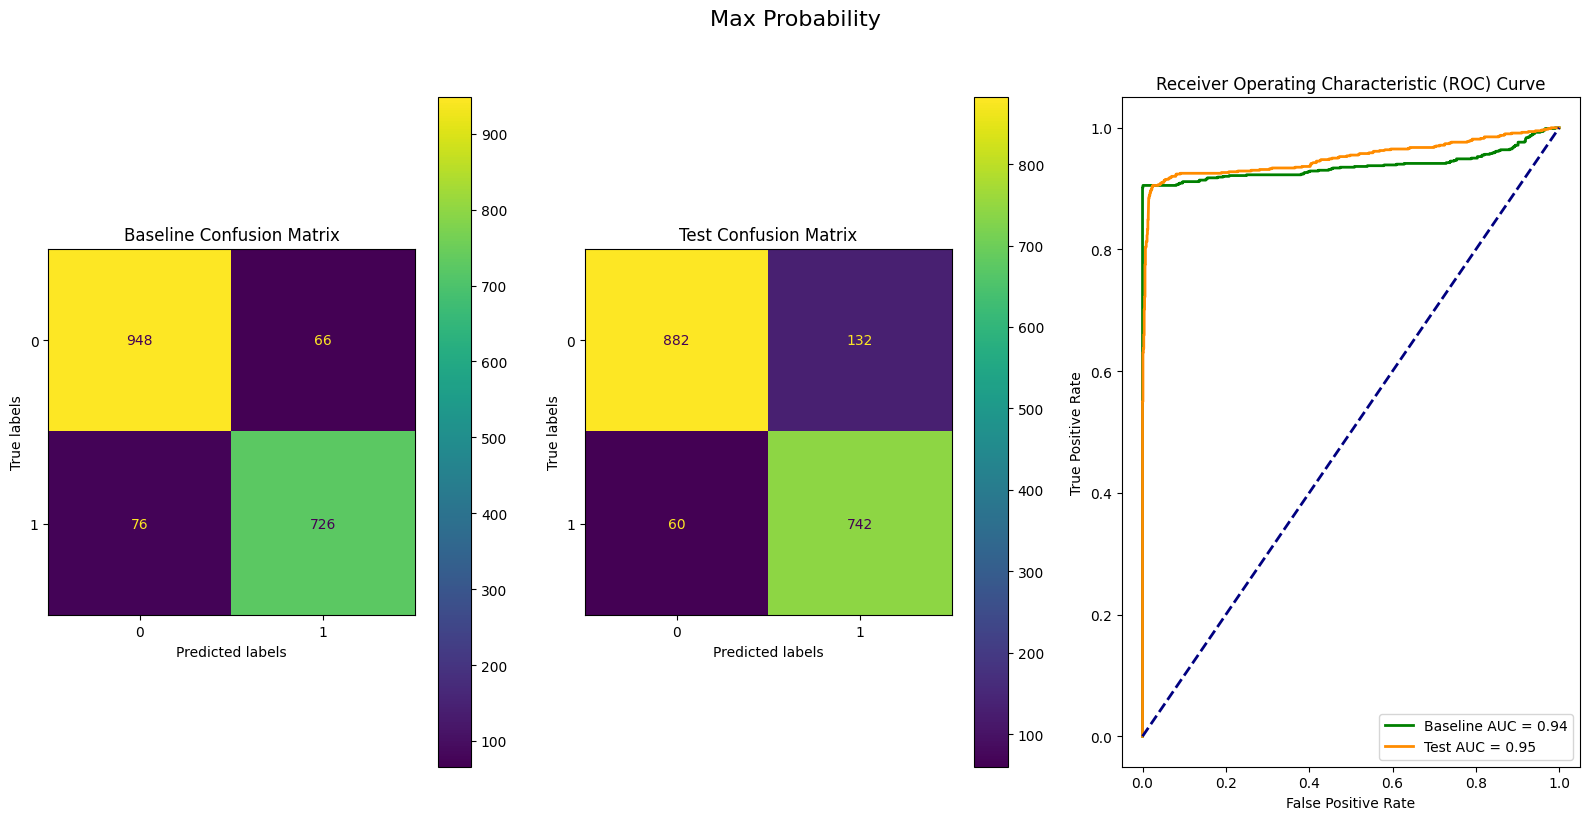

In [27]:
baseline_metrics = calc_metrics(y_test,max_base_predict)
print(f"Baseline:\naccuracy {baseline_metrics['accuracy']:.2f}\nf1 {baseline_metrics['f1']:.2f}\nfar {baseline_metrics['far']:.2f}\nmar {baseline_metrics['mar']:.2f}")
test_metrics = calc_metrics(y_test,max_test_predict)
print(f"Test:\naccuracy {test_metrics['accuracy']:.2f}\nf1 {test_metrics['f1']:.2f}\nfar {test_metrics['far']:.2f}\nmar {test_metrics['mar']:.2f}")

plot(baseline_metrics, test_metrics, title = 'Max Probability')